In [1]:
!pip install kagglehub
from google.colab import files

import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [02:05<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [2]:
import os

# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

# Count the number of folders in a directory
def count_folders(path):
    if os.path.exists(path):
        return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Count the number of files in a directory
def count_files(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Function to count files in each folder of a given directory
def count_files_in_folders(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return {}

    folder_file_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder] = file_count

    return folder_file_counts

# Print counts
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Number of folders in valid_path: {count_folders(valid_path)}")
print(f"Number of files in test_path: {count_files(test_path)}")
print('-------------------------------------------------------------------')
# Count files in each folder
train_folder_counts = count_files_in_folders(train_path)
valid_folder_counts = count_files_in_folders(valid_path)
# Display results
print("Files in each folder (train_path):")
for folder, count in train_folder_counts.items():
    print(f"{folder}: {count} files")

print("\nFiles in each folder (valid_path):")
for folder, count in valid_folder_counts.items():
    print(f"{folder}: {count} files")

Number of folders in train_path: 38
Number of folders in valid_path: 38
Number of files in test_path: 33
-------------------------------------------------------------------
Files in each folder (train_path):
Apple___Apple_scab: 2016 files
Orange___Haunglongbing_(Citrus_greening): 2010 files
Peach___healthy: 1728 files
Apple___Cedar_apple_rust: 1760 files
Tomato___Septoria_leaf_spot: 1745 files
Tomato___Leaf_Mold: 1882 files
Peach___Bacterial_spot: 1838 files
Grape___Black_rot: 1888 files
Tomato___healthy: 1926 files
Cherry_(including_sour)___Powdery_mildew: 1683 files
Corn_(maize)___Northern_Leaf_Blight: 1908 files
Pepper,_bell___Bacterial_spot: 1913 files
Tomato___Bacterial_spot: 1702 files
Tomato___Tomato_mosaic_virus: 1790 files
Potato___Early_blight: 1939 files
Corn_(maize)___healthy: 1859 files
Potato___healthy: 1824 files
Apple___Black_rot: 1987 files
Soybean___healthy: 2022 files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 files
Grape___Esca_(Black_Measles): 1920 files
Cherry_(

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import glob
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Initialize lists
image_paths = []
species_labels = []
disease_labels = []
dataset_split = []

# Function to process a dataset directory
def process_directory(base_path, split_name):
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            species, disease = class_folder.split('___')
            for image_name in os.listdir(class_folder_path):
                image_paths.append(os.path.join(class_folder_path, image_name))
                species_labels.append(species)
                disease_labels.append(disease)
                dataset_split.append(split_name)

# Process train and valid
process_directory(train_path, 'train')
process_directory(valid_path, 'valid')

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'species': species_labels,
    'disease': disease_labels,
    'split': dataset_split
})

# Display first few rows
print(df.head())

                                          image_path species     disease  \
0  /root/.cache/kagglehub/datasets/vipoooool/new-...   Apple  Apple_scab   
1  /root/.cache/kagglehub/datasets/vipoooool/new-...   Apple  Apple_scab   
2  /root/.cache/kagglehub/datasets/vipoooool/new-...   Apple  Apple_scab   
3  /root/.cache/kagglehub/datasets/vipoooool/new-...   Apple  Apple_scab   
4  /root/.cache/kagglehub/datasets/vipoooool/new-...   Apple  Apple_scab   

   split  
0  train  
1  train  
2  train  
3  train  
4  train  


Reduced training data to 20K

In [5]:
train_df = df[df['split'] == 'train']

# Calculate the desired proportion for each class
class_proportions = train_df['species'].value_counts(normalize=True)

# Calculate the number of images per class for the reduced dataset
class_counts = (class_proportions * 20000).astype(int)

# Create a new directory for the reduced dataset
reduced_train_path = '/content/reduced_train'
os.makedirs(reduced_train_path, exist_ok=True)

# Copy images to the new directory, maintaining proportions
for species, count in class_counts.items():
    # Filter DataFrame for the current species
    species_df = train_df[train_df['species'] == species]

    # Randomly select 'count' images from the species
    selected_images = species_df.sample(count, random_state=42)  # Set random_state for reproducibility

    # Create a subdirectory for the species in the reduced dataset
    species_dir = os.path.join(reduced_train_path, species)
    os.makedirs(species_dir, exist_ok=True)

    # Copy the selected images to the new subdirectory
    for _, row in selected_images.iterrows():
        shutil.copy(row['image_path'], species_dir)

print(f"Reduced training dataset created at: {reduced_train_path}")

Reduced training dataset created at: /content/reduced_train


LeNet model Niels

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Adjust input shape if needed
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_counts), activation='softmax')])  # Output layer with the number of classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    reduced_train_path,
    target_size=(128, 128),  # Adjust target size if needed
    batch_size=32,
    class_mode='categorical')

# Training the model
model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 19991 images belonging to 14 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 111s 170ms/step - accuracy: 0.3476 - loss: 2.0520
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.4062 - loss: 1.4353 
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


624/624 ━━━━━━━━━━━━━━━━━━━━ 134s 161ms/step - accuracy: 0.6008 - loss: 1.1566
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.6562 - loss: 0.9543 
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 107s 170ms/step - accuracy: 0.7168 - loss: 0.8234
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.7500 - loss: 0.5895 
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 0.7926 - loss: 0.6115
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.8750 - loss: 0.3855 
Epoch 9/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 138s 161ms/step - accuracy: 0.8265 - loss: 0.5174
Epoch 10/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.8438 - loss: 0.3232 
Epoch 11/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 106s 169ms/step - accuracy: 0.8556 - loss: 0.4242
Epoch 12/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.8438 - loss: 0.3258 
Epoch 13/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 102s 162ms/step - accuracy: 0.8703 - loss: 0.3915
Epoch 14/20
624/624 ━━━━━━━

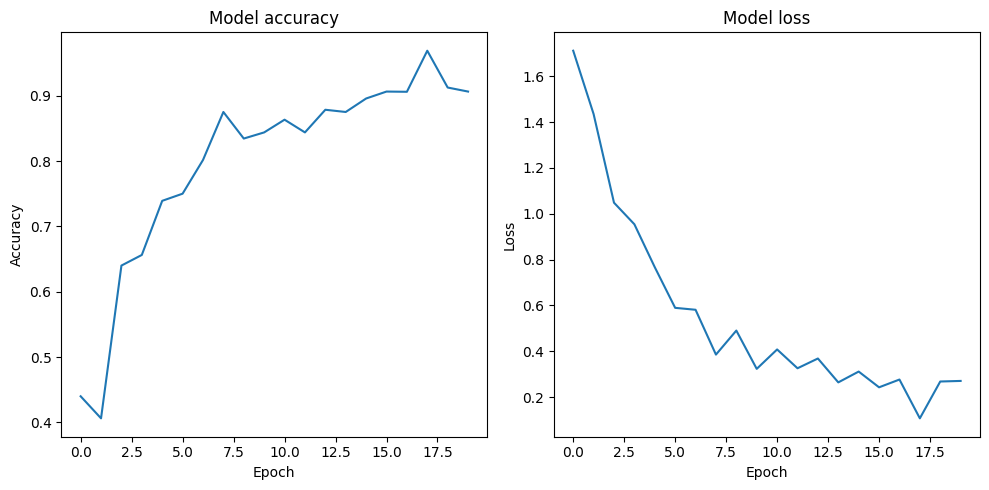

In [9]:
history = model.history

# Plot training accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()